# Predictions

This notebook contains prediction models (regressions, random forests and boosting algorithms) to predict delays.

We split the prediction problem into two different ones, namely a regression problem and a classification problem. The regression problem looks at how much a given flight will be delayed, and the classification problem looks at whether the flight will be delayed or not (with a 15 minute threshold). Cancelled flights cannot be included in the regression problem because the target variable is undefined, but they still contain valuable information and will instead be included in the classification model. Therefore, the regression analysis looks at the delay given that the plane has taken off.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, roc_curve, auc

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                            RandomForestClassifier, GradientBoostingClassifier)

import dataframe_image as dfi

from helper_functions import preprocessor, train_models, roc_auc_plot

### Loading the Data

In [2]:
# Load data
airlines = pd.read_csv("data/airlines.csv")
airports = pd.read_csv("data/airports.csv")
flights = pd.read_csv("data/filtered_flights.csv")

### Preprocessing of the Data

We only keep the variables in the data that are known before the plane takes off, i.e. everything that is planned (for instance, it would not make sense to use the actual time of takeoff to predict whether the flight is delayed, as we want to simulate the prediction being calculated before the plane takes off).

In [3]:
# The following columns will not be used for predicting delays.
remove_cols = ["DEPARTURE_TIME", "DEPARTURE_DELAY", "TAXI_OUT", "WHEELS_OFF", "ELAPSED_TIME",
               "AIR_TIME", "WHEELS_ON", "TAXI_IN", "ARRIVAL_TIME", "AIR_SYSTEM_DELAY", 
               "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]
# We also get rid of FLIGHT_NUMBER and TAIL_NUMBER as these have too many unique values
# to encode them meaningfully.
remove_cols.extend(["FLIGHT_NUMBER", "TAIL_NUMBER"])

# Dropping the columns
flights = flights.drop(columns=remove_cols)

Below, some simple feature engineering is done to a few of the variables.

In [4]:
# Convert SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL to hour of day to reduce the number of unique values
flights["SCHEDULED_DEPARTURE"] = (np.floor(flights["SCHEDULED_DEPARTURE"] / 100)).astype(int)
flights["SCHEDULED_ARRIVAL"] = (np.floor(flights["SCHEDULED_ARRIVAL"] / 100)).astype(int)

Defining the target variables of the regression and classification models.

In [5]:
# In the regression problem, we predict arrival delay in minutes
target_reg = "ARRIVAL_DELAY"

# In the classification problem, we predict whether the flight was on time.
# We start by defining "on time" threshold as 15 minutes
on_time_threshold = 15

# Then we create a new variable saying whether a flight was on time.
# In the get_data.ipynb notebook, the data is filtered so that all remaining nan
# values in the ARRIVAL_DELAY variable correspond to the the flights that were 
# cancelled. Therefore, the nan values in the below arr_on_time variable need to be 0,
# which they are, when done as below.
flights["arr_on_time"] = (flights["ARRIVAL_DELAY"] <= on_time_threshold).astype(int)
target_cla = "arr_on_time"

We do a shared train/test split for the regression and classification problem, so that we can train the models on the same data, and evaluate on the same test dataset as well.

In [6]:
# Defining X and y (one y for each problem)
X_full = flights.drop(columns=[target_reg, target_cla])
y_reg = flights[target_reg]
y_cla = flights[target_cla]

# Train/test split using a test data size of 30%
X_train, X_test, y_reg_train, y_reg_test, y_cla_train, y_cla_test = train_test_split(
    X_full, y_reg, y_cla, test_size=0.3, random_state=42)

Defining the preprocessing of the data that needs to be done before we can input into the models. We do not need to standardize the data, as we are not using any regularization that requires this.

In [7]:
# Defining the transformers of the categorical (one hot encoding) and numeric variables (none)
preprocessor = preprocessor(X_train, ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])

### Training the Models

We start by defining the models that we are going to use to predict the delays.

In [8]:
# Regression models
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest 1": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Random Forest 2": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    "Gradient Boosting 1": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Gradient Boosting 2": GradientBoostingRegressor(n_estimators=200, learning_rate=0.03, random_state=42)
}

# Classification models
cla_models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000, penalty=None), # Does not converge
    "Random Forest 1": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Random Forest 2": RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42),
    "Gradient Boosting 1": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Gradient Boosting 2": GradientBoostingClassifier(n_estimators=200, learning_rate=0.03, random_state=42)
}

Now we are ready for training the models

In [9]:
# Training of the regression models
results_reg = train_models("regression", reg_models, preprocessor, X_train, y_reg_train, X_test, y_reg_test)

Training models: 100%|██████████| 5/5 [53:40<00:00, 644.17s/it]


In [10]:
# Training of the classification models
results_cla = train_models("classification", cla_models, preprocessor, X_train, y_cla_train, X_test, y_cla_test)

Training models: 100%|██████████| 4/4 [34:20<00:00, 515.19s/it]


### Evaluating Performances

Creating a dataframe containing the results of all our models.

We also include a baseline row that shows the performance of a simple model that predicts the mean delay for all flights in the regression task and corresponds to random guessing in the classification task. This means that for the models to actually be useful, their performances must exceed these baseline values.

In [11]:
# Concatenating our results and showing them in a table
performances = pd.concat(
    [pd.Series(results_reg, name="RMSE (Regression)"),
     pd.Series({key: value["roc_auc"] for key, value in results_cla.items()}, 
               name="ROC-AUC (Classification)")],
    axis=1
)

# Creating the baseline row
performances.loc["Baseline"] = [
    # The baseline RMSE is the standard deviation of the test response
    np.std(y_reg_test),
    
    # Random guessing in a classification problem corresponds to a ROC-AUC of 0.5
    0.5
]

# Specifying column order for dfi to work
col_order = ["RMSE (Regression)", "ROC-AUC (Classification)"]
performances = performances[col_order]

# Saving table as an image
dfi.export(performances, "figures/performances_reg_cla.png", table_conversion="matplotlib")

# Showing the table
performances

,RMSE (Regression),ROC-AUC (Classification)
Linear Regression,36.651434,NaN
Random Forest 1,36.546263,0.662337
Random Forest 2,35.455082,0.711770
Gradient Boosting 1,36.230892,0.697493
Gradient Boosting 2,36.353638,0.684421
Baseline,37.122034,0.500000


#### Predictions
Across all regression models, the RMSE values are very similar and lie in the range of 35.46-36.65 minutes. Since the standard deviation of the arrival delay in the test set is 37.12 minutes, the predictive performance of all the regression models is very close to the simple baseline that predicts the mean delay (which would result in a RMSE equal to the standard deviation). This indicates that the variables used contain only limited information for predicting the exact magnitude of arrival delays, which is somewhat expected, as many of the actual drivers of delays, such as weather and air traffic congestion, are not explicitly included in the dataset.

For the classification task, the Random Forest and Gradient Boosting models achieve ROC-AUC scores of 0.66-0.71. These values are clearly above 0.5, which corresponds to random guessing, indicating a moderate but still limited ability to distinguish between on-time and delayed flights.

#### Comparing the Models
For the regression problem, Random Forest 2 delivers the best regression performance. The improvement of Random Forest 2 relative to Random Forest 1 can be attributed to its greater tree depth (max_depth = 15 vs. 5), which gives the model a way to capture more complex non-linear relationships in the data at the cost of slightly higher variance.

For the classification problem, Random Forest 2 again achieves the highest score, here in the form of ROC-AUC, indicating the strongest discriminatory power across all models. The performance of this model can again be explained by its increased tree depth.

The Gradient Boosting models also show consistent performance in both regression and classification. However, they do not outperform Random Forest 2. When comparing the two Gradient Boosting models, the results indicate that a higher learning rate combined with fewer boosting stages yields better predictive performance.

#### Summary
In summary, the results show that while the models are able to capture some structure in the data for delay classification, their ability to accurately predict the exact delay amount is limited.

#### Plotting ROC-AUC
Lastly, we plot a ROC-AUC curve showing the trade-off between the TPR and the FPR across different classification thresholds for each model.

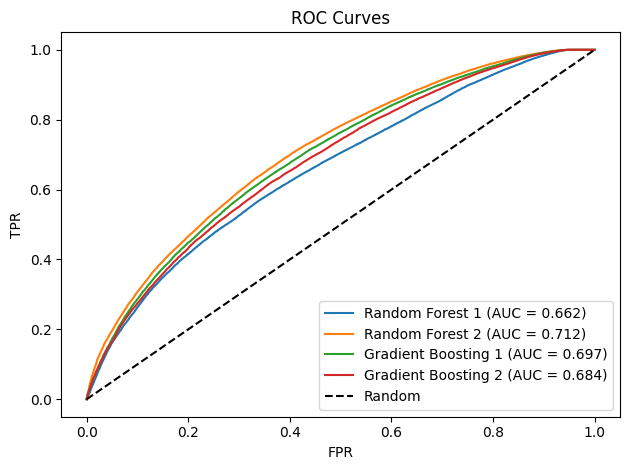

<Figure size 640x480 with 0 Axes>

In [12]:
# Plotting the ROC-AUC
roc_auc_plot(results_cla, "figures/classification_roc.png")

The ROC curves confirm that the Random Forest and Gradient Boosting classifiers achieve a moderate level of performance, with AUC values between 0.66-0.71, indicating a reasonable but still limited ability to distinguish between on-time and delayed flights.